<a href="https://colab.research.google.com/github/majidraeis/RL_Based_AdmissionControl/blob/master/RLearning_Tandem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Queueing Network environment (Continuous time)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import os
import gym
from gym import spaces
import copy
import gc
import functools
import operator
import random
from google.colab import files
import matplotlib.pyplot as plt
import tkinter as tk
from tqdm import tqdm
import numpy as np
import matplotlib
from matplotlib import style
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


class TandemEnv(gym.Env):
    """
    Define a multi-server queue.
    The environment defines the admission control problem in a multi-server queue.
    Action: accept(1) or reject(0), State: 1-queue length 2-#of busy servers
    """
    def __init__(self, N_s, Mu_s, rho, d_th, lam, p_eps):
       self.t_arr = 0
       self.job_index = 1
       self.N_s = N_s
       self.Mu_s = Mu_s
       self.cnt = 1
       self.d_th = d_th
       self.rho = rho
       self.p_eps = p_eps
       self.lag_lambda = lam
       self.MAX_STEPS = 1000
       self.dep_vec = []
       self.action_space = spaces.Discrete(2)
       B_max = 60
       self.observation_space = [spaces.Discrete(B_max)]*len(N_s)
       self.qls = np.zeros(len(N_s),dtype=int)
       self.tandem = Tandem(N_s, Mu_s)
       self.tandem_job_dict = {}
       self.opt_flags = {}
       self.cost = 0

    def step(self, action, opt_flag):
        s = self.qls
        index = self.job_index
        self._take_action(action)
        s_prime = self.qls
        reward_vec = []
        delay_vec = []
        if not action:
          virtual_Qnet = copy.deepcopy(self.tandem)
          v_flag = True
          time = np.copy(self.t_arr)
          info_vec = np.zeros((2,3))
          info_vec[0] = [index, time, 1]
          time += 5
          info_vec[1] = [0, time, 0]
          while(v_flag):
            # print('input to vnet=',info_vec, 'index=', index)
            # print('---------')
            _, dep_vec = virtual_Qnet._step(info_vec)
            # print('output from vnet=',dep_vec)
            # print('---------')
            departed_indices = dep_vec[:,0]
            if index in departed_indices:
              v_flag = False
              v_delay = 0
              for n_s in range(len(self.N_s)):
                v_delay += virtual_Qnet.queue[n_s].job_dict[index]['Tw']   
              v_delay += virtual_Qnet.queue[n_s].job_dict[index]['Ts'] 
              # v_delay = virtual_Qnet.queue[0].job_dict[index]['Tw']+ virtual_Qnet.queue[0].job_dict[index]['Ts'] 

            info_vec[0] = [0, time, 0]
            time += 5
            info_vec[1] = [0, time, 0]
          del(virtual_Qnet)
          reward = self._get_reward(v_delay, action) 
          reward_vec.append([s, action, s_prime, reward, opt_flag])
          if v_delay < self.d_th: 
            self.cost += 1
        else:
          self.tandem_job_dict[index] = {}
          self.tandem_job_dict[index]['s'] = s
          self.tandem_job_dict[index]['s_prime'] = s_prime
          self.opt_flags[index] = opt_flag

        for j in range(0, self.dep_vec.shape[0]-1):
          index = int(self.dep_vec[j][0])
          delay = 0
          for n_s in range(len(self.N_s)):
            assert(not np.isnan(self.tandem.queue[n_s].job_dict[index]['Tw'])), 'Nan error'
            delay += self.tandem.queue[n_s].job_dict[index]['Tw']   
          delay += self.tandem.queue[n_s].job_dict[index]['Ts'] 
          for n_s in range(len(self.N_s)):
            del(self.tandem.queue[n_s].job_dict[index])

          s = self.tandem_job_dict[index]['s']
          s_prime = self.tandem_job_dict[index]['s_prime']
          reward = self._get_reward(delay, action)       
          reward_vec.append([s, 1, s_prime, reward, self.opt_flags[index]]) #delayed reward, action =1
          delay_vec.append(delay)
  
        done = False if self.cnt < self.MAX_STEPS else True
        self.cnt += 1
        return self.qls, reward_vec, done, delay_vec

    def _take_action(self, action):
        info_vec = np.zeros((2,3))
        info_vec[0] = [self.job_index, self.t_arr, action]
        self.job_index += 1
        self.t_arr = self.t_arr + self._inter_arr_gen()
        info_vec[1] = [self.job_index, self.t_arr, 0]
        self.qls, self.dep_vec = self.tandem._step(info_vec)

    def _get_reward(self, delay, action):

        if action:
          r = self.p_eps*self.lag_lambda if delay <= self.d_th else -(1-self.p_eps)*self.lag_lambda
        else:
          r = -1 if delay <= self.d_th else 0
        return r

    def _inter_arr_gen(self):
        c_a2 = 0.7 #SCV^2
        lambda_a = self.N_s[0] * self.rho * self.Mu_s[0]
        mean = 1/lambda_a
        k = 1/c_a2
        theta = mean/k
        interTa = np.random.gamma(k, theta)
        return interTa
    
    def reset(self):

        self.t_arr = 0
        self.job_index = 1
        self.cnt = 1
        self.qls = np.zeros(len(self.N_s), dtype=int)
        self.dep_vec = []
        self.tandem_job_dict = {}
        self.opt_flags = {}
        self.tandem = Tandem(self.N_s, self.Mu_s)
        self.cost = 0
        return self.qls
"------------------------------------------------"  

class Tandem():
    def __init__(self, N_s, Mu_s):
        #         self.__version__ = "0.1.0"
        # General variables defining the environment
        self.N_s = N_s
        self.Mu_s = Mu_s
        self.queue = []
        self.ql = np.zeros(len(N_s), dtype=int)
        for i,n_s in enumerate(self.N_s):
          self.queue.append(Queue(n_s, self.Mu_s[i]))

    def _step(self, info_vec):
        info_vec_new = np.copy(info_vec)
        for i in range(len(self.N_s)):
          self.ql[i], departure_vec = self.queue[i]._progress(info_vec_new) 
          if np.shape(departure_vec)[0]>1:
            ind_sorted = np.argsort(departure_vec[:,1])
            departure_vec = departure_vec[ind_sorted] 
          info_vec_new = np.append(departure_vec,info_vec[-1]).reshape(-1, 3)
        return self.ql, info_vec_new

class Fork():
    def __init__(self, N_s, Mu_s, P_s):
        #         self.__version__ = "0.1.0"
        # General variables defining the environment
        self.N_s = N_s
        self.P_s = P_s
        self.queue = []
        self.ql = np.zeros(len(N_s), dtype=int)
        for i,n_s in enumerate(self.N_s):
          self.queue.append(Queue(n_s, Mu_s[i]))

    def _step(self, info_vec):
        info_vec_perFork = {}
        arrival_cnt = info_vec.shape[0]-1
        info_vec_new = np.copy(info_vec)
        picked_queue = np.random.multinomial(1, self.P_s, size=arrival_cnt)
        picked_queue = np.argmax(picked_queue, axis=1)
        for i in range(len(self.N_s)):
          
          info_vec_perFork[i] = np.append(info_vec_new[:-1][picked_queue == i], info_vec_new[-1]).reshape(-1, 3)
          self.ql[i], departure_vec = self.queue[i]._progress(info_vec_perFork[i]) 
          if np.shape(departure_vec)[0]>1:
            ind_sorted = np.argsort(departure_vec[:,1])
            departure_vec = departure_vec[ind_sorted] 
          info_vec_perFork[i] = np.append(departure_vec,info_vec[-1]).reshape(-1, 3)
        return self.ql, info_vec_perFork        

class Join():
    def __init__(self, n_s, mu_s):
        #         self.__version__ = "0.1.0"
        # General variables defining the environment
        self.ql = 0
        self.queue = Queue(n_s, mu_s)

    def _step(self, info_vec):
        info_vec_new = []
        self.N_branch = len(list(info_vec.keys()))
        for i in range(self.N_branch):
          info_vec_new = np.append(info_vec_new, info_vec[i][:-1]).reshape(-1, 3)
        if np.shape(info_vec_new)[0]>1:
          ind_sorted = np.argsort(info_vec_new[:,1])
          info_vec_new = info_vec_new[ind_sorted] 
        info_vec_new = np.append(info_vec_new,info_vec[i][-1]).reshape(-1, 3)
        self.ql, departure_vec = self.queue._progress(info_vec_new)
        info_vec_new = np.append(departure_vec,info_vec[i][-1]).reshape(-1, 3)
        return self.ql, departure_vec 

class Queue():
    def __init__(self, n_s, mu_s):
        #         self.__version__ = "0.1.0"
        # General variables defining the environment
        self.n_servers = n_s
        self.n_jobs = 0
        self.ql_vec = [0]
        self.empty_servers = np.arange(n_s)
        self.assigned_servers = []
        self.t_fin = []
        self.ind_fin = []
        self.job_dict = {}
        self.job_dict[0] = {'Tw': 0.0, 'Ts':0.0}
        self.mu_s = mu_s
    def _progress(self, info_vec):
        # Queue length before taking the action (upon job arrival)
        departure_vec = []
        assert(np.shape(info_vec)[0]>=1), 'error'
        for j in range(np.shape(info_vec)[0]-1):
          job_index = int(info_vec[j][0])
          time = info_vec[j][1]
          isArrival = info_vec[j][2]
          self.ql = max(self.n_jobs - self.n_servers, 0) # before arrival
          if isArrival:
              if self.n_jobs < self.n_servers:
                  t_ent = time
                  self.empty_servers = [x for x in range(self.n_servers) if x not in self.assigned_servers]
                  self.assigned_servers = np.append(self.assigned_servers, random.choice(self.empty_servers))

              else:
                  # finding the time that each server gets empty
                  t_available = [np.max(self.t_fin[self.assigned_servers == i]) for i in range(self.n_servers)]
                  # pick the earliest server available
                  picked_server = np.argmin(t_available)
                  t_ent = max(time, t_available[picked_server])
                  self.assigned_servers = np.append(self.assigned_servers, picked_server)

              t_s = self._service_gen()
              self.t_fin = np.append(self.t_fin, t_ent + t_s)
              self.ind_fin = np.append(self.ind_fin, job_index)
              self.n_jobs += 1
              self.job_dict[job_index] = {'Ta': time, 'Td': t_ent + t_s, 'Ts': t_s, 'Tw': t_ent- time,
                                              'Ba': self.ql}

          next_time = info_vec[j+1][1]
          self.n_jobs -= np.sum(np.array(self.t_fin) < next_time)
          served_jobs = np.arange(len(self.t_fin))[np.array(self.t_fin) < next_time]
          for i in served_jobs:
            departure_vec.append([int(self.ind_fin[i]), self.t_fin[i], 1])
          self.t_fin = np.delete(self.t_fin, served_jobs)
          self.ind_fin = np.delete(self.ind_fin, served_jobs)
          self.assigned_servers = np.delete(self.assigned_servers, served_jobs)

        if np.shape(info_vec)[0]==1:
          next_time = info_vec[0][1]
          self.n_jobs -= np.sum(np.array(self.t_fin) < next_time)
          served_jobs = np.arange(len(self.t_fin))[np.array(self.t_fin) < next_time]
          for i in served_jobs:
            departure_vec.append([int(self.ind_fin[i]), self.t_fin[i], 1])
          self.t_fin = np.delete(self.t_fin, served_jobs)
          self.ind_fin = np.delete(self.ind_fin, served_jobs)
          self.assigned_servers = np.delete(self.assigned_servers, served_jobs)

        QL = max(self.n_jobs - self.n_servers, 0) # queue length of this stage before the next arrival to the first stage
        return QL, np.array(departure_vec)

    def _service_gen(self):
        c_s2 = 0.8 #SCV^2
        mean = 1/self.mu_s
        k = 1/c_s2
        theta = mean/k
        Ts = np.random.gamma(k, theta)
        # lambda_s = 1.0
        # return np.random.exponential(1 / lambda_s)
        return Ts


# Admission Control in Tandem Queueing Systems (Continuous time)
![alt text](https://raw.githubusercontent.com/majidraeis/Figs/master/queue.png)

## Goal:
Consider a tandem multi-server queueing system with $N$ stages. We want to learn an admission control policy that gurantees $P(d>d_{th}|a=A)<\epsilon$ and achieves a high throuput as well.

## State ($\bar{s}$):
$\bar{s}=(s_1, s_2, \cdots, s_N)$

i.e., the vector of queue lengths of all the stages upon arrival of a packet 
## Actions ($a$):
Accept or Reject the incoming packet
## Reward ( $R(s,a)$ ):
>

\begin{equation*}
r = \left\{
\begin{array}{ll}
+1,  \qquad & a = Accept & d<d_{th}\\ 
0,  \qquad & a = Accept & d>d_{th}\\
r_R,  \qquad & a = Reject 
\end{array} \right.
\end{equation*}
\
\begin{align}
\bar{R}&=P(a=A)P(d<d_{th}|a=A)+P(a=R)r_R\\
&=P(a=A)\left[P(d<d_{th}|a=A)-r_R\right]+r_R
\end{align}
.
- This reward function guarantees $P(d<d_{th}|a=A)>r_R$ if it is feasible, otherwise $P(A)=0$. Therefore, we can set $r_R=1-\epsilon$ to guarantee $P(d>d_{th}|a=A)<\epsilon$.
-If $r_R=0$, the optimal policy maximizes $\bar{R}=P(a=A)P(d<d_{th}|a=A)$. This can be used for maximizing the throughput in scenarios with an end-to-end deadline of $d_{th}$.

Although the above reward function guarantees $P(d<d_{th}|a=A)>r_R$, it might not result in the optimal throughput ($P(a=A)$).

We extend the reward function as foloowing. Even if we reject a packet, we imagine what would happen if we let the packet in and what would be the delay. Based on this delay, we can assess if the rejection was a right thing to do or not.


\begin{equation*}
r = \left\{
\begin{array}{ll}
r^A_1,  \qquad & a = Accept & d<d_{th}\\ 
r^A_2,  \qquad & a = Accept & d>d_{th}\\
r^R_1,  \qquad & a = Reject & d<d_{th}\\
r^R_2,  \qquad & a = Reject & d>d_{th}
\end{array} \right.
\end{equation*}

Consider $r^A_1=1$, $r^A_2=0$ and $r^R_1 \leq r^R_2$. Then we have:

\begin{align}
\bar{R}&=P(a=A)\left[P(d<d_{th}|a=A)-r^R_2\right]\\
&+P(a=R)\left[P(d<d_{th}|a=R).(r^R_1-r^R_2)\right]+r^R_2.
\end{align}

It is similar to the previous case with the difference that we are penalizing unnecessary rejections (could have $d<d_{th}$).

If we want a policy that $P(d>d_{th}|a=A)<\epsilon$ and optimizes the throughput as well:
- set $r^R_2$ to $1-\epsilon$,
- Adjust $r^R_1 \in [0,r^R_2]$ to get a larger throughput, while $P(d>d_{th}|a=A)<\epsilon$ is not violated.


##Notes:
- Even the immediate rewards ($r$) have delay, i.e., we have to wait until the packets have gone through the whole network and then calculate the end-to-end delay and therefore the reward!!

- When $a$= Accept, the immediate reward is not a deterministic function of $\bar{s}$ and $a$.  

##Solution to delayed rewards:
- One possible solution is using the same idea as **experience replay** for DQN. 

- At each step, we only update the Q-table (R-table in continueing case) for experiences that have known $e2e$ delay.
>- If we reject the packet, we immediately update the Q table, since $r = -1$
>- If we accept a packet, we store the state of the system upon arrival of that packet($\bar{s}$), and the next state of the system upon arrival of the next packet ($\bar{s}'$),
>- once the packet is departed, the Q table is updated with experience $(\bar{s}, a=1, \bar{s}', r)$.

As a result, we might freeze the Q table for a few time steps until we have a departure so that we can update the table. (During this time, the exploration is done based on the freezed table)


In [ ]:
class Agent():
    def __init__(self, env):
        self.isCont = \
            type(env.action_space) == gym.spaces.box.Box
        if self.isCont:
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape

        else:
            self.action_size = env.action_space.n

    def get_action(self):
        if self.isCont:
            action = np.random.uniform(self.action_low, self.action_high, self.action_shape)
        else:
            action = random.choice(range(env.action_space.n))
        return action

"------------R_LEARNING FOR TANDEM---------------"
"------------------------------------------------"
class RAgent(Agent):
    def __init__(self, env, learning_rate=0.01):
        super().__init__(env)
        self.observation_space_vec = np.array([i.n for i in env.observation_space])
        self.table_tuple = tuple(np.append(self.observation_space_vec, self.action_size))
        self.learning_rate = learning_rate
        self.eps = 0.5
        self.beta = 0.01
        self.mean_reward = 0
        self.build_model()

    def build_model(self):
        self.r_table = 1 * np.random.random(self.table_tuple)

    def get_action(self, state):
        s = state
        state_ind = tuple(np.minimum(s, self.observation_space_vec-1))
        # print(state_ind, s)
        r_state = self.r_table[state_ind]
        action_greedy = np.argmax(r_state)
        action_random = super().get_action()
        if random.random() < self.eps:
            self.optimal = False
            return action_random
        else:
            self.optimal = True
            return action_greedy

    def train(self, experience, opt_flag):
        s, action, next_s, reward, done = experience
        state_ind = tuple(np.minimum(next_s, self.observation_space_vec-1))
        # print(state_ind, s)
        r_next = self.r_table[state_ind]
        r_next = np.zeros([self.action_size]) if done else r_next
        r_target = reward - self.mean_reward + np.max(r_next)
        state_action_ind = tuple(np.append(np.minimum(s, self.observation_space_vec-1), action))
        r_update = r_target - self.r_table[state_action_ind]
        self.r_table[state_action_ind] += self.learning_rate * r_update
        if opt_flag:
            self.mean_reward = self.mean_reward + self.beta * r_update
        if done:
            self.eps *= 0.98
            self.eps = max(self.eps, 0.01)

In [ ]:
"------------Q_LEARNING FOR TANDEM---------------"
"------------------------------------------------"
class QAgent(Agent):
    def __init__(self, env, discount_rate=1, learning_rate=0.01):
        super().__init__(env)
        self.observation_space_vec = np.array([i.n for i in env.observation_space])
        self.table_tuple = tuple(np.append(self.observation_space_vec, self.action_size))
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        self.eps = 0.5
        self.build_model()

    def build_model(self):
        self.r_table = 1 * np.random.random(self.table_tuple)

    def get_action(self, state):
        s = state
        state_ind = tuple(np.minimum(s, self.observation_space_vec-1))
        # print(state_ind, s)
        r_state = self.r_table[state_ind]
        action_greedy = np.argmax(r_state)
        action_random = super().get_action()
        if random.random() < self.eps:
            self.optimal = False
            return action_random
        else:
            self.optimal = True
            return action_greedy

    def train(self, experience, opt_flag):
        s, action, next_s, reward, done = experience
        state_ind = tuple(np.minimum(next_s, self.observation_space_vec-1))
        # print(state_ind, s)
        r_next = self.r_table[state_ind]
        r_next = np.zeros([self.action_size]) if done else r_next
        r_target = reward + self.discount_rate * np.max(r_next)
        state_action_ind = tuple(np.append(np.minimum(s, self.observation_space_vec-1), action))
        r_update = r_target - self.r_table[state_action_ind]
        self.r_table[state_action_ind] += self.learning_rate * r_update

        if done:
            self.eps *= 0.99
            self.eps = max(self.eps, 0.05)

100%|██████████| 500/500 [11:11<00:00,  1.34s/it]


Text(0.5, 0, 'Episodes')

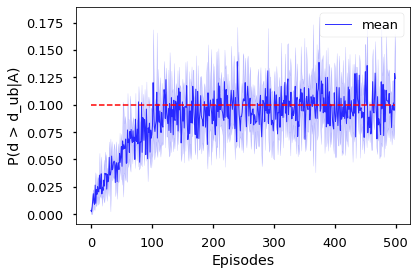

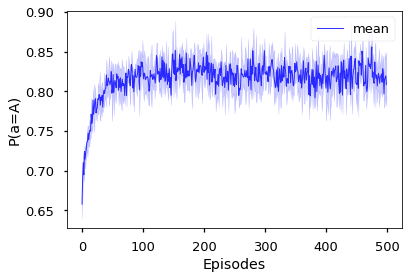

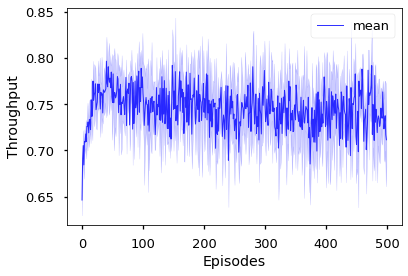

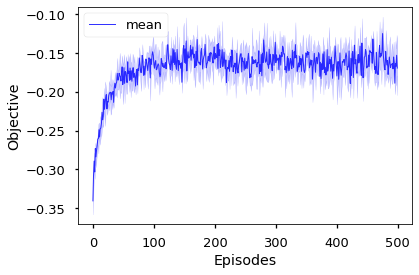

In [ ]:
np.random.seed(5)
render_flag = False
d_th = 15
ep_length = 500
rho = 0.95
lam = 8
# lam = 10
p_eps = 0.1
# N_s = [5,3,2]
# Mu_s = [1.0/5, 1.0/3, 1.0/2]
N_s = [3,5,2]
Mu_s = [1.0/3, 1.0/5, 1.0/2]

# seed_vec = np.random.randint(1,100,1)
seed_vec = [3,100,16,20]
# seed_vec = [3]
ave_reward = np.zeros((len(seed_vec), ep_length))
ave_delay = np.zeros((len(seed_vec), ep_length))
Prob_delay = np.zeros((len(seed_vec), ep_length))
Prob_action = np.zeros((len(seed_vec), ep_length))
throughput = np.zeros((len(seed_vec), ep_length))
objective = np.zeros((len(seed_vec), ep_length))
eps = np.zeros((len(seed_vec), ep_length))

for sd_index, sd in enumerate(seed_vec):
  # print(sd_index, sd)
  np.random.seed(sd)
  env = TandemEnv(N_s,Mu_s,rho,d_th,lam,p_eps)
  agent = RAgent(env)
  state = env.reset()
  done = False
  for ep in tqdm(range(ep_length)):   

    ave_reward[sd_index, ep] = ave_reward[sd_index, ep-1] if ep>0 else 0
    done = False
    cnt_act = 1
    env.cnt = 1
    env.cost = 0
    delays = []
    action_vec = []
    while not done:
        action = agent.get_action(state)
        action_vec.append(action)
        next_state, reward_vec, done, info = env.step(action, agent.optimal)
        delays.append(info)
        for i, k in enumerate(reward_vec):
          [s, action, next_s, reward, opt_flag] = k
          agent.train((s, action, next_s, reward, done), opt_flag)
          ave_reward[sd_index, ep] += (reward - ave_reward[sd_index, ep])/cnt_act
          cnt_act += 1
        state = next_state

    
    delay_flatten = np.array(functools.reduce(operator.iconcat, delays, [])) # only contains the accepted packets
    Prob_action[sd_index, ep] = np.mean(action_vec)if len(action_vec)>0 else 0
    ave_delay[sd_index, ep] = np.mean(delay_flatten) if len(delay_flatten)>0 else 0
    throughput[sd_index, ep] = np.sum(delay_flatten<=d_th) if len(delay_flatten)>0 else 0
    throughput[sd_index, ep] = throughput[sd_index, ep]/(env.MAX_STEPS)
    Prob_delay[sd_index, ep] = np.mean(np.array(delay_flatten) > d_th) if len(delay_flatten)>0 else 0
    eps[sd_index, ep] = agent.eps
    objective[sd_index, ep] = - env.cost/env.MAX_STEPS
  # print(eps)


  
fig_directory = '/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/figs/tandem'
file_directory = '/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/files/tandem'
if not os.path.exists(fig_directory):
    os.makedirs(fig_directory)
if not os.path.exists(file_directory):
    os.makedirs(file_directory)

np.save(f'/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/files/tandem/Rtable2.npy',agent.r_table)
np.save(f'/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/files/tandem/Prob_delay2.npy',Prob_delay)
np.save(f'/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/files/tandem/Prob_action2.npy',Prob_action)
np.save(f'/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/files/tandem/throughput2.npy',throughput)
np.save(f'/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/files/tandem/objective2.npy',objective)

Prob_delay_mean = np.mean(Prob_delay, axis = 0)
Prob_delay_std = np.std(Prob_delay, axis = 0)
fig1, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(ep_length), Prob_delay_mean, alpha=0.8, color='b', label='mean', linewidth = 1.0)
ax.plot(np.arange(ep_length), 0.1*np.ones(ep_length), '--r', linewidth = 1.5)
ax.fill_between(np.arange(ep_length), Prob_delay_mean - Prob_delay_std, Prob_delay_mean + Prob_delay_std, color='b', alpha=0.2)
ax.legend(loc='best')
# ax.set_xlim(0,250)
# ax.set_ylim(0,0.25)
ax.set_ylabel("P(d > d_ub|A)")
ax.set_xlabel("Episodes")
# plt.savefig(fig_directory + '/Prob_violation.pdf',bbox_inches='tight')

Prob_action_mean = np.mean(Prob_action, axis = 0)
Prob_action_std = np.std(Prob_action, axis = 0)
fig2, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(ep_length), Prob_action_mean, alpha=0.8, color='b', label='mean', linewidth = 1.0)
ax.fill_between(np.arange(ep_length), Prob_action_mean - Prob_action_std, Prob_action_mean + Prob_action_std, color='b', alpha=0.2)
ax.legend(loc='best')
# ax.set_xlim(0,250)
# ax.set_ylim(0.4,1)
ax.set_ylabel('P(a=A)')
ax.set_xlabel("Episodes")
# plt.savefig(fig_directory + '/Prob_action.pdf',bbox_inches='tight')

throughput_mean = np.mean(throughput, axis = 0)
throughput_std = np.std(throughput, axis = 0)
fig3, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(ep_length), throughput_mean, alpha=0.8, color='b', label='mean', linewidth = 1.0)
ax.fill_between(np.arange(ep_length), throughput_mean - throughput_std, throughput_mean + throughput_std, color='b', alpha=0.2)
ax.legend(loc='best')
# ax.set_xlim(0,250)
# ax.set_ylim(0.2,1)
ax.set_ylabel('Throughput')
ax.set_xlabel("Episodes")
# plt.savefig(fig_directory + '/throughput.pdf',bbox_inches='tight')


objective_mean = np.mean(objective, axis = 0)
objective_std = np.std(objective, axis = 0)
fig4, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.arange(ep_length), objective_mean, alpha=0.8, color='b', label='mean', linewidth = 1.0)
ax.fill_between(np.arange(ep_length), objective_mean - objective_std, objective_mean + objective_std, color='b', alpha=0.2)
ax.legend(loc='best')
# ax.set_xlim(0,250)
ax.set_ylabel('Objective')
ax.set_xlabel("Episodes")
# plt.savefig(fig_directory + '/objective.pdf',bbox_inches='tight')

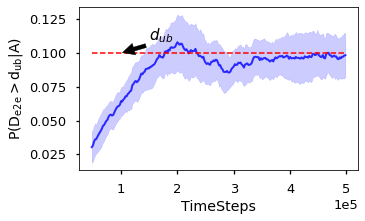

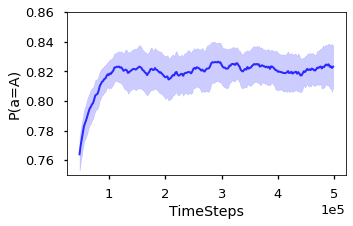

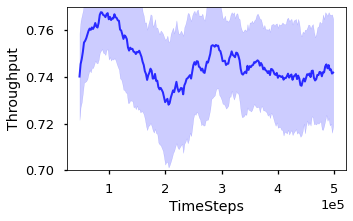

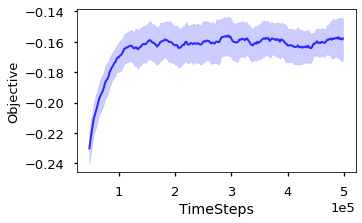

In [ ]:
style.use('seaborn-talk')
from scipy import stats
import pandas as pd
# ep_length = 1000
ep_length = 500
def mov_average(in_series, window_size):
  pd_series = pd.Series(in_series)
  windows = pd_series.rolling(window_size)
  moving_averages = windows.mean()
  moving_averages_list = moving_averages.tolist()
  without_nans = moving_averages_list[window_size - 1:]
  return np.array(without_nans)

fig_directory = '/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/figs/tandem'
file_directory = '/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/files/tandem'
if not os.path.exists(fig_directory):
    os.makedirs(fig_directory)
if not os.path.exists(file_directory):
    os.makedirs(file_directory)

Prob_delay = np.load('/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/files/tandem/Prob_delay2.npy')
Prob_action = np.load('/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/files/tandem/Prob_action2.npy')
throughput = np.load('/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/files/tandem/throughput2.npy')
objective = np.load('/content/gdrive/My Drive/Colab Notebooks/RL for Queueing/files/tandem/objective2.npy')


window_size = 25
step = 2
episodes = np.arange(ep_length)
sample = np.arange(0,ep_length,step)
episodes = episodes[sample]
episodes = episodes[window_size-1:]
steps = episodes*1000

Prob_delay_mean = np.mean(Prob_delay, axis = 0)[sample]
Prob_delay_se = stats.sem(Prob_delay, axis = 0)[sample]
Prob_delay_mean = mov_average(Prob_delay_mean, window_size)
Prob_delay_se = mov_average(Prob_delay_se, window_size)


fig1, ax = plt.subplots(figsize=(5, 3))
ax.plot(steps, Prob_delay_mean, alpha=0.8, color='b', label='mean', linewidth = 2.0)
ax.plot(steps, 0.1*np.ones(len(episodes)), '--r', linewidth = 1.5)
ax.fill_between(steps, Prob_delay_mean - Prob_delay_se, Prob_delay_mean + Prob_delay_se, color='b', alpha=0.2)
# ax.legend(loc='best')
# ax.set_xlim(0,250)
# ax.set_ylim(0,0.15)
ax.set_ylabel(r"$\rm P(D_{e2e} > d_{ub}|A)$", fontsize=14)
ax.set_xlabel("TimeSteps")
ax.annotate('$d_{ub}$',
            xy=(100000, .100),
            xycoords='data',
            xytext=(150000, .12),size=15,
            arrowprops=
                dict(facecolor='black', shrink=0.05),
                horizontalalignment='left',
                verticalalignment='top')
plt.ticklabel_format(style='sci', axis='x', scilimits=(6,0))
plt.savefig(fig_directory + '/Prob_violation.pdf',bbox_inches='tight')

Prob_action_mean = np.mean(Prob_action, axis = 0)[sample]
Prob_action_se = stats.sem(Prob_action, axis = 0)[sample]
Prob_action_mean = mov_average(Prob_action_mean, window_size)
Prob_action_se = mov_average(Prob_action_se, window_size)

fig2, ax = plt.subplots(figsize=(5, 3))
ax.plot(steps, Prob_action_mean, alpha=0.8, color='b', label='mean', linewidth = 2.0)
ax.fill_between(steps, Prob_action_mean - Prob_action_se, Prob_action_mean + Prob_action_se, color='b', alpha=0.2)
# ax.legend(loc='best')
# ax.set_xlim(0,250)
ax.set_ylim(0.75,0.86)
ax.set_ylabel('P(a=A)')
ax.set_xlabel("TimeSteps")
plt.ticklabel_format(style='sci', axis='x', scilimits=(6,0))
plt.savefig(fig_directory + '/Prob_action.pdf',bbox_inches='tight')

throughput_mean = np.mean(throughput, axis = 0)[sample]
throughput_se = stats.sem(throughput, axis = 0)[sample]
throughput_mean = mov_average(throughput_mean, window_size)
throughput_se = mov_average(throughput_se, window_size)

fig3, ax = plt.subplots(figsize=(5, 3))
ax.plot(steps, throughput_mean, alpha=0.8, color='b', label='mean', linewidth = 2.0)
ax.fill_between(steps, throughput_mean - throughput_se, throughput_mean + throughput_se, color='b', alpha=0.2)
# ax.legend(loc='best')
# ax.set_xlim(0,250)
ax.set_ylim(0.7,0.77)
ax.set_ylabel('Throughput')
ax.set_xlabel("TimeSteps")
plt.ticklabel_format(style='sci', axis='x', scilimits=(6,0))
plt.savefig(fig_directory + '/throughput.pdf',bbox_inches='tight')


objective_mean = np.mean(objective, axis = 0)[sample]
objective_se = stats.sem(objective, axis = 0)[sample]
objective_mean = mov_average(objective_mean, window_size)
objective_se = mov_average(objective_se, window_size)

fig4, ax = plt.subplots(figsize=(5, 3))
ax.plot(steps, objective_mean, alpha=0.8, color='b', label='mean', linewidth = 2.0)
ax.fill_between(steps, objective_mean - objective_se, objective_mean + objective_se, color='b', alpha=0.2)
# ax.legend(loc='best')
# ax.set_xlim(0,250)
ax.set_ylabel('Objective', fontsize=13)
ax.set_xlabel("TimeSteps")
plt.ticklabel_format(style='sci', axis='x', scilimits=(6,0))
plt.savefig(fig_directory + '/objective.pdf',bbox_inches='tight')

In [ ]:
from google.colab import files
files.download(fig_directory + '/objective.pdf')

In [ ]:
# import seaborn
style.use('seaborn-talk')


#Without Control

In [ ]:
render_flag = False
d_th = 15
ep_length = 500
rho = 0.95
lam = 10,
p_eps = 0.1
# N_s = [5,3,2]
# Mu_s = [1.0/5, 1.0/3, 1.0/2]
N_s = [3,5,2]
Mu_s = [1.0/3, 1.0/5, 1.0/2]

seed_vec = np.random.randint(1,100,2)
np.random.seed(10)
render_flag = False
# d_th = 10
ep_length = 550
# rho = 0.95
# # N_s = [5,3,2]
# # Mu_s = [1.0/5, 1.0/3, 1.0/2]
# N_s = [5,3]
# Mu_s = [1.0/5, 1.0/3]
env = TandemEnv(N_s,Mu_s,rho,d_th,lam,p_eps)
state = env.reset()
cnt_act = 1
delays = []
for ep in tqdm(range(ep_length)):   

  done = False
  env.cnt = 1
  action_vec = []
  while not done:

      action = 1
      next_state, reward_vec, done, info = env.step(action, True)
      delays.append(info)
      state = next_state

delay_flatten = np.array(functools.reduce(operator.iconcat, delays, []))
ave_delay = np.mean(delay_flatten) if len(delay_flatten)>0 else 0
Prob_delay = np.mean(np.array(delay_flatten) > d_th) if len(delay_flatten)>0 else 0

print('ave_delay=%3.2f, P(d>d_th)=%3.2f'%(ave_delay, Prob_delay))


100%|██████████| 550/550 [06:26<00:00,  1.42it/s]

ave_delay=41.44, P(d>d_th)=0.88
